# **SUPERSTORE SALES ANALYSIS**
___
by: Fadhiil Dzaki Mulyana

# Library

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data viz
from matplotlib import pyplot as plt, dates as mdates
import seaborn as sns

# map
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import branca.colormap as cm

In [30]:
# overview
def check_overview(df):
    '''
    df_overview adalah fungsi yang digunakan untuk melihat informasi seputar dataset.

    Argumen:
    df = dataset yang digunakan.

    Output:
    Informasi overall dataset, missing value, duplicated value dan jumlah unique value setiap kolom.
    '''
    # df overview
    print(df.info())

    # cek missing value
    print(f"\nmissing values: {round(((df.isna().sum().sum())/len(df))*100, 2)}% \n{df.isna().sum()[df.isna().sum()>0]}")

    # cek duplicated value
    print(f"\nduplicated values: {round(((df.duplicated().sum())/len(df))*100,2)}% \n{df.duplicated().sum()}\n")

    # cek nama kolom & jumlah unique value
    for col in df:
        print(f'{col}-#nunique: {df[col].nunique()}')

# fungsi cek deskriptif stats
def check_deskriptif(df, kolom):
    '''
    Fungsi ini digunakan untuk mengetahui statistik deskriptif.

    Argumen:
    - df = DataFrame
    - kolom = List dari kolom numerik

    Return:
    - DataFrame yang berisi deskriptif statistik data.
    '''
    # deskriptif stats
    deskriptif = df[kolom].describe().T

    # desc stats
    deskriptif = df[kolom].describe().T

    # empty list to store kolom's sums
    sums = []

    # loop calculate sum of feature
    for i in kolom:
        # calculate sum of feature
        total = df[i].sum()

        # add sum to empty list
        sums.append(total)

    # create sum column
    deskriptif['sum'] = sums

    # List untuk menyimpan nilai
    skewness_values = []
    jenis_skewness = []

    # Loop untuk menghitung skewness dan kurtosis setiap kolom
    for i in kolom:
        # Menghitung skewness
        skew = df[i].skew()
        skewness_values.append(skew)
        
        # Menentukan jenis skewness
        if -0.5 <= skew <= 0.5:
            jenis_skewness.append('normal')
        else:
            jenis_skewness.append('skewed')

    # Membuat kolom baru dalam deskriptif
    deskriptif['skewness'] = skewness_values
    deskriptif['jenis_skewness'] = jenis_skewness

    return deskriptif

# fungsi cek outlier
def check_outlier(df, kolom):
    '''
    argumen:
    df = dataframe
    kolom = kolom numerik [list]
    multiplier = pengkali dalam metode IQR (1.5 / 3)
    '''
    # mengecek deskriptif stats
    deskriptif = check_deskriptif(df,kolom)

    # batas atas
    upper_fence = []
    #batas bawah
    lower_fence = []
    # persentase outlier
    percent_outlier = []

    # looping untuk mengisi list kosong
    for i in kolom:
        # bentuk distribusi
        bentuk_dist = deskriptif['jenis_skewness'][i]
        # besar skewness
        besar_skew = deskriptif['skewness'][i]

        # jika bentuk distribusi skew
        if bentuk_dist == 'skewed':
            # jika outlier kecil
            if -1 < besar_skew < 1:
                # mencari Q1,Q2 dan IQR
                Q3 = df[i].quantile(0.75)
                Q1 = df[i].quantile(0.25)
                IQR = Q3-Q1
                
                # menghitung boundaries
                batas_bawah = Q1-1.5*IQR
                batas_atas = Q3+1.5*IQR
            # jika outlier extreeme
            else:
                # mencari Q1,Q2 dan IQR
                Q3 = df[i].quantile(0.75)
                Q1 = df[i].quantile(0.25)
                IQR = Q3-Q1
                # menghitung boundaries
                batas_bawah = Q1-3*IQR
                batas_atas = Q3+3*IQR

        # jika bentuk distribusi normal
        else:
            # rata2 dan st. deviasi
            avg = df[i].mean()
            std = df[i].std()

            # boundaries
            batas_atas = avg + 3*std
            batas_bawah = avg - 3*std

        # menghitung persentase outlier
        persentase_out = ((len(df[df[i] > batas_atas]) / len(df) * 100) + (len(df[df[i] < batas_bawah]) / len(df) * 100))
        persentase_out = round(persentase_out,2)

        # boundaries adn percentage add
        lower_fence.append(batas_bawah)
        upper_fence.append(batas_atas)
        percent_outlier.append(persentase_out)

    # convert to df
    outlier = pd.DataFrame({
        'batas_atas': upper_fence,
        'batas_bawah': lower_fence,
        'persentase' : percent_outlier},
        index=kolom
        )
    # mengembalikan outlier
    return outlier

# Function to format annotations
def annotate_bars(plot, fmt="{:,.0f}K", formater=1000):
    for container in plot.containers:
        labels = [fmt.format(val / formater) for val in container.datavalues]
        plot.bar_label(container, labels=labels, label_type='edge')

# Introduction

## Dataset Information
The Superstore Dataset offers a comprehensive platform to delve into the dynamics of sales operations, customer interactions, and the factors that drive business success. It contains information from diverse regions and segments, enabling the exploration of trends, patterns, and correlations in sales and customer preferences. The dataset is specific to the United States and covers a time span from 2014 to 2017.

Column |Descriptions 
-------|-------------
Row ID | Unique ID for each row.
Order ID | Unique Order ID for each Customer.
Order Date | Order Date of the product.
Ship Date | Shipping Date of the Product.
Ship Mode| Shipping Mode specified by the Customer.
Customer ID | Unique ID to identify each Customer.
Customer Name | Name of the Customer.
Segment | The segment where the Customer belongs.
Country | Country of residence of the Customer.
City | City of residence of of the Customer.
State | State of residence of the Customer.
Postal Code | Postal Code of every Customer.
Region | Region where the Customer belong.
Product ID | Unique ID of the Product.
Category | Category of the product ordered.
Sub-Category | Sub-Category of the product ordered.
Product Name | Name of the Product
Sales | Sales of the Product.
Quantity | Quantity of the Product.
Discount | Discount provided.
Profit | Profit/Loss incurred.

## Background
Superstore is a retail company based in the United States specialize in selling furniture, office supplies, and technology products. As a Data Analyst, they asked me to identify weaknesses and opportunities within their business to enhance their business growth and profitability.

## Problem Statement
Enhancing Superstore profit margin up to 15% by identifying weaknesses and opportunities in sales performance, customer segmentation, shipping logistics, etc. By leveraging the Superstore dataset from 2014 to 2017 and collaborating with internal teams, the company will implement actionable improvements within a 12-month timeframe, with quarterly progress reviews to ensure timely adjustments and refinements.

## Problem Breakdown
1. What are the KPIs?
2. Are there noticeable trends or seasonal variations in sales and customer preferences?
3. How effective are the current discount strategies? Do they lead to an increase in sales volume and profitability?
4. Are there specific products, categories, or regions that are underperforming or overperforming?
5. Which states and cities are generating the highest revenue?
5. Which customer segment is bringing in the most profit?
6. What is the most preferred shipping mode among our customers?
7. How effective are the current discount strategies? Do they lead to an increase in sales volume and profitability?

# Data Loading

In [3]:
# load data
df = pd.read_csv("sample_-_superstore(orders).csv", encoding='latin1')

# display all column
pd.set_option('display.max_columns',None)

# change column name to snake case
df.columns = df.columns.str.lower().str.replace('[ -]', '_', regex=True)

# show data
df.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
# overall check
check_overview(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   row_id         9994 non-null   int64  
 1   order_id       9994 non-null   object 
 2   order_date     9994 non-null   object 
 3   ship_date      9994 non-null   object 
 4   ship_mode      9994 non-null   object 
 5   customer_id    9994 non-null   object 
 6   customer_name  9994 non-null   object 
 7   segment        9994 non-null   object 
 8   country        9994 non-null   object 
 9   city           9994 non-null   object 
 10  state          9994 non-null   object 
 11  postal_code    9994 non-null   int64  
 12  region         9994 non-null   object 
 13  product_id     9994 non-null   object 
 14  category       9994 non-null   object 
 15  sub_category   9994 non-null   object 
 16  product_name   9994 non-null   object 
 17  sales          9994 non-null   float64
 18  quantity

**Dataset:**   
The dataset contains 9994 rows and 21 columns:
- Categorical columns: 'row_id', 'order_id', 'ship_mode', 'customer_id', 'customer_name', 'segment', 'country', 'city', 'state', 'postal_code', 'region', 'product_id', 'category', 'sub-category', 'product_name'
- Numerical columns: 'sales', 'quantity', 'discount', 'profit'
- Temporal columns: 'order_date, 'ship_date'

Several columns seems to have wrong data type:
- temporal columns data type must be datetime and must be changed to provide high quality dataset.

**Missing & Duplicated Values:**   
There is no missing or duplicated value.

**Cardinality:**
- it's normal for id columns to have so many unique value since they are an unique identifier.
- 'country' only has 1 unique value, USA, and not provide any valuable information.

# Data Cleaning & Preparation

## Outlier Check

In [5]:
# numeric features
num = ['sales', 'quantity', 'discount', 'profit']

check_outlier(df,num)

,batas_atas,batas_bawah,persentase
sales,787.92000,-560.700,6.68
quantity,14.00000,-7.000,0.00
discount,0.80000,-0.600,0.00
profit,112.26975,-81.177,11.69


## Data Type Manipulation

### Temporal Data to datetime

In [6]:
# define wrong dtype column
wrong_dtype = ['order_date', 'ship_date']

# loop for changing data type
for i in wrong_dtype:
    # change wit    h format mm/dd/yyyy
    df[i] = pd.to_datetime(df[i], format='%m/%d/%Y')

# check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   row_id         9994 non-null   int64         
 1   order_id       9994 non-null   object        
 2   order_date     9994 non-null   datetime64[ns]
 3   ship_date      9994 non-null   datetime64[ns]
 4   ship_mode      9994 non-null   object        
 5   customer_id    9994 non-null   object        
 6   customer_name  9994 non-null   object        
 7   segment        9994 non-null   object        
 8   country        9994 non-null   object        
 9   city           9994 non-null   object        
 10  state          9994 non-null   object        
 11  postal_code    9994 non-null   int64         
 12  region         9994 non-null   object        
 13  product_id     9994 non-null   object        
 14  category       9994 non-null   object        
 15  sub_category   9994 n

In [7]:
# save
df_dtype = df.copy()

In [8]:
# load
df = df_dtype.copy()

## Feature Creation

### Profit Margin
Profit Margin = (Profit/Sales)*100

In [9]:
# create profit margin
df['profit_margin'] = (df['profit']/df['sales'])*100

# check
df.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit,profit_margin
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,16.00
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,30.00
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,47.00
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,-40.00
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,11.25


In [10]:
# save
df_pmargin = df.copy()

In [11]:
# load
df = df_pmargin.copy()

### Shipping Time
shipping_time = ship date - order date

In [12]:
# create column shipping time
df['shipping_time'] = df['ship_date'] - df['order_date']

# check_d
df[['shipping_time']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   shipping_time  9994 non-null   timedelta64[ns]
dtypes: timedelta64[ns](1)
memory usage: 78.2 KB


## Feature Selection

In [13]:
# drop Country
df.drop(columns='country', inplace=True)

# check
check_overview(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   row_id         9994 non-null   int64          
 1   order_id       9994 non-null   object         
 2   order_date     9994 non-null   datetime64[ns] 
 3   ship_date      9994 non-null   datetime64[ns] 
 4   ship_mode      9994 non-null   object         
 5   customer_id    9994 non-null   object         
 6   customer_name  9994 non-null   object         
 7   segment        9994 non-null   object         
 8   city           9994 non-null   object         
 9   state          9994 non-null   object         
 10  postal_code    9994 non-null   int64          
 11  region         9994 non-null   object         
 12  product_id     9994 non-null   object         
 13  category       9994 non-null   object         
 14  sub_category   9994 non-null   object         
 15  prod

# Exploratory Data Analysis

### Customer per Region

In [14]:
# customer per region
user_region = df.groupby('region')['customer_id'].nunique().sort_values(ascending=False)

print('Total Customers:',df['customer_id'].nunique(),'\n')

print(user_region)

Total Customers: 793 

region
West       686
East       674
Central    629
South      512
Name: customer_id, dtype: int64


**Moving Around Customers:**   
If we total customer from every region there are more than 793 and since there could be double counting, it means that we had customers moving around regions.

**West area - the bigest market of all**   
The West area have the biggest market followed by east and central without significant different, while south have the lowest market that significantly different.

## KPI's

In [15]:
# define kpi columns
kpi = ['sales', 'quantity', 'profit', 'profit_margin']

# desc stats
desc_kpi = check_deskriptif(df,kpi)

# show
desc_kpi

,count,mean,std,min,25%,50%,75%,max,sum,skewness,jenis_skewness
sales,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.940,22638.480,2.297201e+06,12.972752,skewed
quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000,3.787300e+04,1.278545,skewed
profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976,2.863970e+05,7.561432,skewed
profit_margin,9994.0,12.031393,46.675435,-275.000,7.50000,27.0000,36.250,50.000,1.202417e+05,-2.894826,skewed


Over the past 4 years, Superstore has generated 2.3M sales and 286,397K profit from 37,873 sold items. The average profit margin is 12.03%. According to [Flintfox](https://www.flintfox.com/resources/articles/increase-profit-margin-retail/#:~:text=What%20is%20retail%20margin?,market%20competition%2C%20and%20operational%20costs.), a 10-20 percent retail profit margin is considered healthy. However, it is still lower than the company's target of 15%.

## Sales & Profit by Region

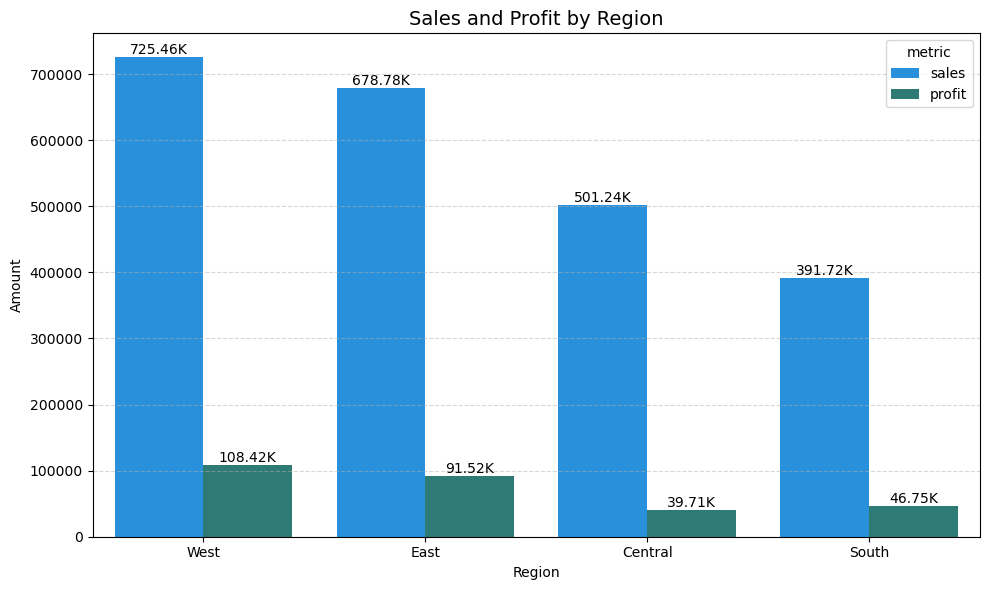

In [32]:
# Group sales & profit by region
regional_sales_profit = df.groupby('region')[['sales', 'profit']].sum().sort_values(by='sales', ascending=False).reset_index()

# Melt the data for easier plotting with seaborn
regional_sales_profit_melted = regional_sales_profit.melt(id_vars='region', value_vars=['sales', 'profit'], var_name='metric', value_name='value')

# Create a canvas
plt.figure(figsize=(10, 6))

# Create grouped bar plot
plot = sns.barplot(data=regional_sales_profit_melted, x='region', y='value', hue='metric', palette=['#0B96F9','#22867E'])

# Add title
plt.title('Sales and Profit by Region', fontsize=14)
plt.xlabel('Region')
plt.ylabel('Amount')
# add gridline
plt.grid(axis='y',linestyle='--', alpha=0.5)

# # add annotate
annotate_bars(plot,"{:,.2f}K")

# Show plot
plt.tight_layout()
plt.show()


## Sales by State

In [17]:
# Group sales & profit by state
state_profit = df.groupby('state')[['sales', 'profit']].sum().round(2).reset_index()

# Get coordinates
geolocator = Nominatim(user_agent="superstore_analysis")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Add coordinates to data
state_profit['coordinates'] = state_profit['state'].apply(geocode)
state_profit['latitude'] = state_profit['coordinates'].apply(lambda loc: loc.latitude if loc else None)
state_profit['longitude'] = state_profit['coordinates'].apply(lambda loc: loc.longitude if loc else None)

# Colormap by sales
max_sales = state_profit['sales'].max()
min_sales = state_profit['sales'].min()
colormap = cm.linear.PuOr_09.scale(min_sales, max_sales)

# Create map
map_profit = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add state marker + popup
for index, row in state_profit.iterrows():
    if not pd.isnull(row['latitude']) and not pd.isnull(row['longitude']):
        folium.CircleMarker(location=(row['latitude'], row['longitude']),
                            radius=8,
                            popup=f"State: {row['state']}<br>Sales: ${row['sales']}<br>Profit: ${row['profit']}",
                            color=colormap(row['sales']),
                            fill=True,
                            fill_color=colormap(row['sales']),
                            fill_opacity=0.7).add_to(map_profit)

# Add legend
colormap.add_to(map_profit)

# Save map
map_profit.save('profit_map.html')

# Show map
map_profit

**West & East Domination**   
The West and the East side have the highest sales percentage due to several Factors such as:
- Urbanization: Urban areas in the West and East, especially California and New York, have a higher concentration of people such as San Francisco, Los Angeles, and New York City that can drive sales & profit.
- Population Density: The West and East regions include states with some of the largest populations, such as California (West) and New York (East).
- Economic Activity: These regions encompass major economic hubs. For example, cities like Los Angeles (West) and New York City (East) are known for their high economic activity.

**Top Performers**   
-  With sales of $457,687.63 and a profit of $76,381.39, California stands out as the top-performing state following by New York with $310,876.27 in sales and $74,038.55 in profit. The high sales volume and significant profit indicate strong demand and effective cost management. the company should consider to focus on marketing efforts and optimizing inventory in those states to further increase sales.

**Underperforming States**  
- Despite having moderate sales of $170,188.05, Texas is experiencing a negative profit of -$25,729.36. This indicates that operational costs, discounts, or other factors are eroding the profitability in the state.

## Sales & Profit by Quarter of Year

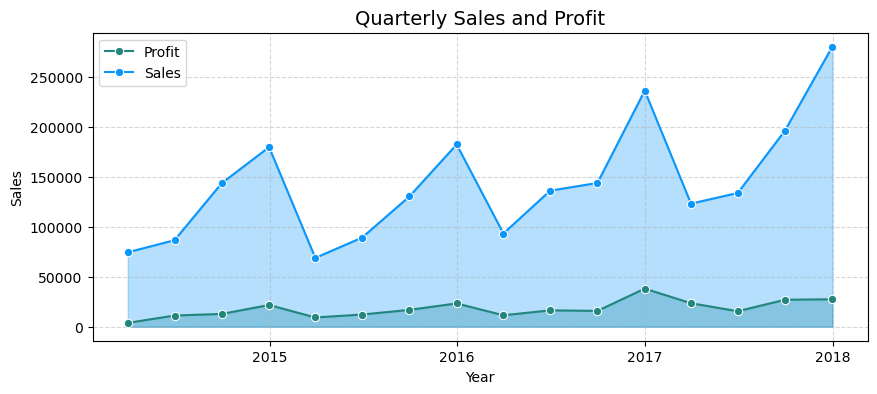

In [18]:
# Calculate daily revenue
daily_revenue = df.groupby('order_date')[['sales', 'profit']].sum().reset_index()

# Sort by order_date and reset index
daily_revenue = daily_revenue.sort_values(by='order_date').reset_index(drop=True)

# Set order_date as index
daily_revenue.set_index('order_date', inplace=True)

# Calculate monthly revenue
quarterly_revenue = daily_revenue.resample('QE').sum()

# create canvas
plt.figure(figsize=(10,4))

# Plot sales and profit
sns.lineplot(x=quarterly_revenue.index, y=quarterly_revenue.profit, label='Profit', marker='o', color='#22867E')
sns.lineplot(x=quarterly_revenue.index, y=quarterly_revenue.sales, label='Sales', marker='o', color='#0B96F9')

# Fill area under the lines
plt.fill_between(quarterly_revenue.index, quarterly_revenue.profit, color='#22867E', alpha=0.3)
plt.fill_between(quarterly_revenue.index, quarterly_revenue.sales, color='#0B96F9', alpha=0.3)

# Set major locator and formatter for x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# set x & y label
plt.xlabel('Year')
plt.ylabel('Sales')
# add title
plt.title('Quarterly Sales and Profit', fontsize=14)
# add legend
plt.legend()
# add gridline
plt.grid(linestyle='--', alpha=0.5)

# show plot
plt.show()

**Seasonality**   
Sales in the first quarter of each year always decline, then increase in the following quarters.The yearly highest sales peak occurs in the last quarter of each year, indicating a strong finish to the year. This could be due to holiday season promotions, increased consumer spending, or successful marketing campaigns. However, profits do not show any seasonality.

**Profit Stability**  
The profit figures remain relatively stable and low compared to the sales figures. Despite increasing sales each year, the profit margins are not improving significantly. This indicates that there might be issues with cost management, pricing strategies, or other factors impacting profitability.

## Sales & Profit by Product Category

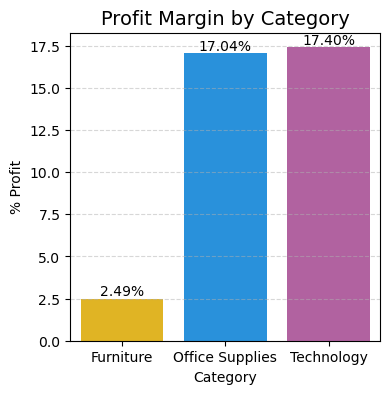

In [40]:
# Group profit & sales by product category
category_sales = df.groupby('category')[['sales','profit']].sum().reset_index()

# profit margin
category_sales['profit_margin'] = category_sales['profit'] / category_sales['sales'] * 100

# Create canvas
plt.figure(figsize=(4, 4))

# bar chart
plot = sns.barplot(data=category_sales,x='category',y='profit_margin', palette= ['#FFC505','#0B96F9','#BE55A7'], hue='category')

# add annotation
annotate_bars(plot,'{:,.2f}%',1,)
        
# add title
plt.title('Profit Margin by Category', fontsize=14)
# set x & y label
plt.xlabel('Category')
plt.ylabel('% Profit')
# add gridline
plt.grid(axis='y',linestyle='--', alpha=0.5)

# show()
plt.show()


In [20]:
category_sales

,category,sales,profit,profit_margin
0,Furniture,741999.7953,18451.2728,2.486695
1,Office Supplies,719047.0320,122490.8008,17.035158
2,Technology,836154.0330,145454.9481,17.395712


- Technology and Office Supplies categories have the highest profit margins, at 17.4% and 17.04% respectively. These categories are crucial for driving overall profitability and should be a focus for strategic growth.
- Furniture has a significantly lower profit margin of 2.49%. Despite having substantial sales ($741,999.80), the profit is quite low ($18,451.27). This suggests that there may be issues with cost management, pricing strategies, or other factors impacting the profitability of furniture sales.

## Sales & Profit by Product

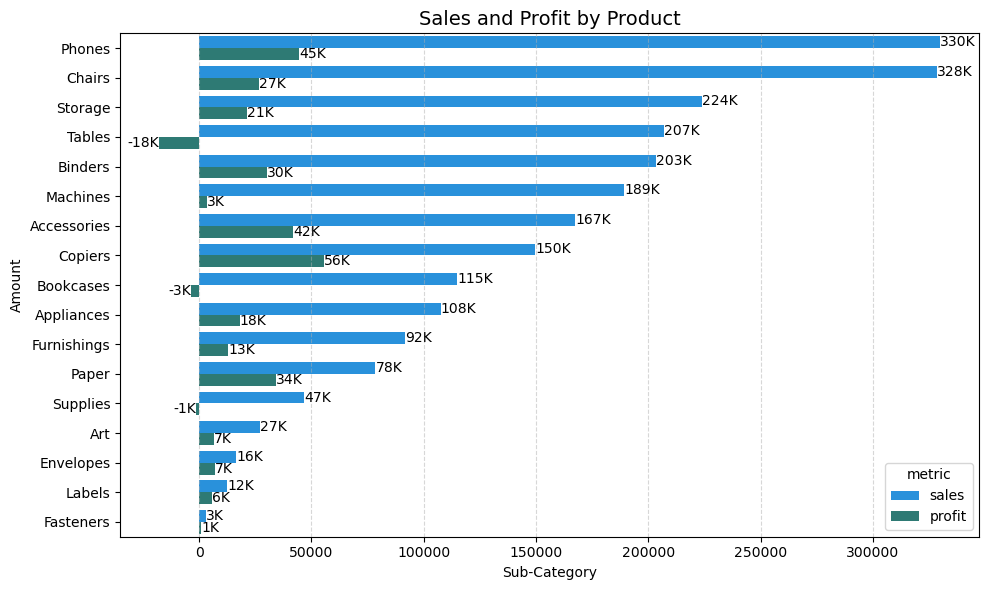

In [29]:
# Group sales & profit by sub category
subcat_sales_profit = df.groupby('sub_category')[['sales', 'profit']].sum().sort_values(by='sales', ascending=False).reset_index()

# Melt the data for easier plotting with seaborn
subcat_sales_profit_melted = subcat_sales_profit.melt(id_vars='sub_category', value_vars=['sales', 'profit'], var_name='metric', value_name='value')

# Create a canvas
plt.figure(figsize=(10, 6))

# Create grouped bar plot
plot = sns.barplot(data=subcat_sales_profit_melted, y='sub_category', x='value', hue='metric', palette=['#0B96F9','#22867E'])

# Add title
plt.title('Sales and Profit by Product', fontsize=14)
plt.xlabel('Sub-Category')
plt.ylabel('Amount')
# add gridline
plt.grid(axis='x',linestyle='--', alpha=0.5)

## add annotation
annotate_bars(plot)

# Show plot
plt.tight_layout()
plt.show()


The Technology category has proven to be the top performer in terms of both sales and profit, with the Phones sub-category particularly excelling in sales and profitability. Conversely, the Furniture category has significant sales but suffers from a low-profit margin. Notably, within Furniture, the Tables sub-category showed reasonable sales but incurred a loss. Additionally, both Bookcases and Supplies have yielded negative profits for the company. These findings suggest that there may be underlying issues with the cost structure or pricing strategy, especially concerning the Tables, Bookcases, and Supplies subcategories.

## Order by Customers Segment

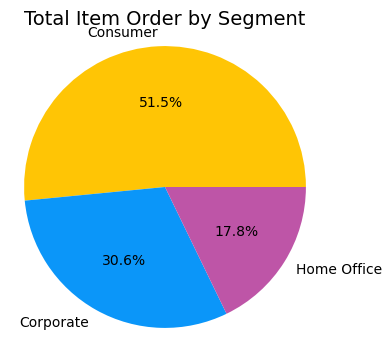

In [22]:
# group quantity by customer segment
segment_order = df.groupby('segment')['quantity'].sum().reset_index()

# create canvas
plt.figure(figsize=(4,4))

# pie prep
size = segment_order['quantity']
label = segment_order['segment']
color3 = ['#FFC505','#0B96F9','#BE55A7']

# pie chart
plt.pie(x=size, labels=label, colors=color3, autopct='%1.1f%%')

# set equal axis
plt.axis('equal')
# add title
plt.title('Total Item Order by Segment', fontsize=14)

# show
plt.show()

**Crucial Segment**   
The majority of orders come from consumer segment, indicating this segment is a crucial driver of Superstore's sales. It's important to continue nurturing and retaining these customers through targeted marketing, loyalty programs, and personalized experiences.

**Growth Opportunities in B2B**  
Both Home Office and Corporate segments, while smaller, present significant growth opportunities. These segments may benefit from focused B2B (Business-to-Business) strategies.

## Shipping Preference

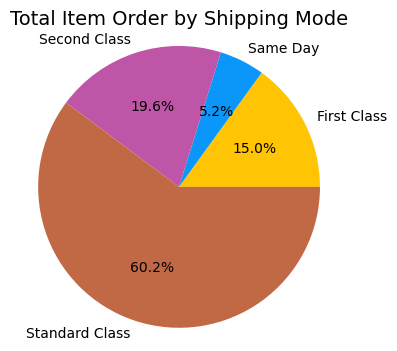

In [23]:
# group quantity by customer ship
ship_order = df.groupby('ship_mode')['quantity'].sum().reset_index()

# create canvas
plt.figure(figsize=(4,4))

# pie prep
size = ship_order['quantity']
label = ship_order['ship_mode']
color4 = ['#FFC505','#0B96F9','#BE55A7','#C06944']

# pie chart
plt.pie(x=size, labels=label, colors=color4, autopct='%1.1f%%')

# set equal axis
plt.axis('equal')
# add title
plt.title('Total Item Order by Shipping Mode', fontsize=14)

# show
plt.show()

**Cost saving > Faster Delivery**   
Most of customers prefer Standard Class shipping the cheapest ship mode. This indicates that customer might proiritize cost saving over faster delivery.

## Sales & Profit Overtime by Segment

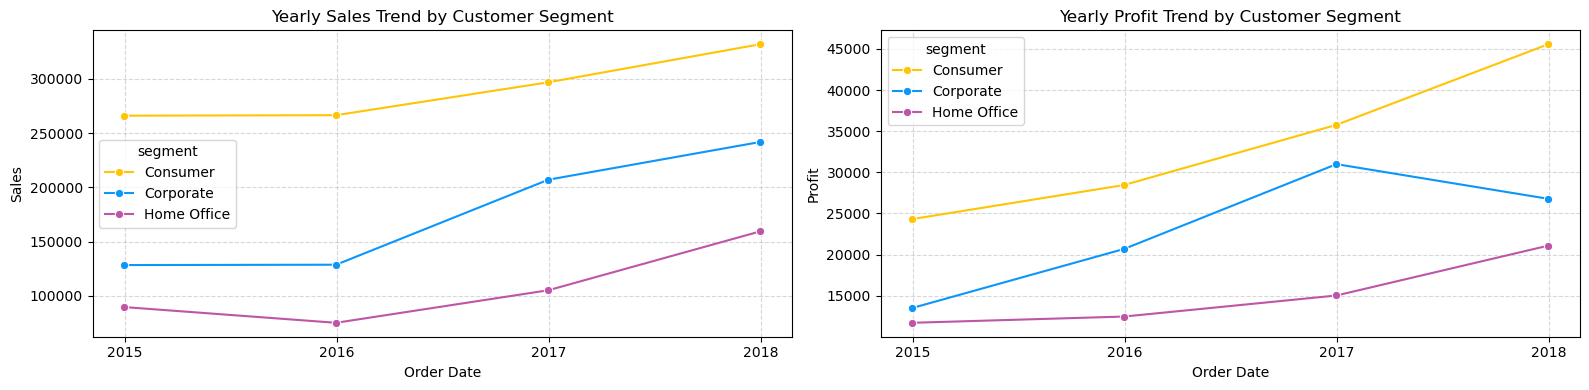

In [24]:
# Calculate daily sales per segment
daily_sales_by_segment = df.groupby(['order_date', 'segment'])['sales'].sum().reset_index()

# Resample to yearly
monthly_sales_by_segment = daily_sales_by_segment.pivot_table(index='order_date', columns='segment', values='sales', aggfunc='sum').resample('YE').sum().reset_index()

# Melt the DataFrame
monthly_sales_melted = monthly_sales_by_segment.melt(id_vars='order_date', var_name='segment', value_name='sales')

# Calculate daily profit per segment
daily_profit_by_segment = df.groupby(['order_date', 'segment'])['profit'].sum().reset_index()

# Resample to yearly
monthly_profit_by_segment = daily_profit_by_segment.pivot_table(index='order_date', columns='segment', values='profit', aggfunc='sum').resample('YE').sum().reset_index()

# Melt the DataFrame
monthly_profit_melted = monthly_profit_by_segment.melt(id_vars='order_date', var_name='segment', value_name='profit')

# Create canvas with 1x2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# color
color = ['#FFC505','#0B96F9','#BE55A7']

# Line plot for sales
sns.lineplot(data=monthly_sales_melted, x='order_date', y='sales', hue='segment', marker='o', ax=ax1, palette=color)
ax1.set_title('Yearly Sales Trend by Customer Segment')
ax1.set_xlabel('Order Date')
ax1.set_ylabel('Sales')
ax1.grid(linestyle='--', alpha=0.5)
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Line plot for profit
sns.lineplot(data=monthly_profit_melted, x='order_date', y='profit', hue='segment', marker='o', ax=ax2, palette=color)
ax2.set_title('Yearly Profit Trend by Customer Segment')
ax2.set_xlabel('Order Date')
ax2.set_ylabel('Profit')
ax2.grid(linestyle='--', alpha=0.5)
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Adjust layout
plt.tight_layout()
plt.show()

**Consumer Profit Align With Sales**   
Given that the Consumer segment has the highest sales, its profitability should ideally reflect this, indicates effective cost management and pricing strategies. it also tell us that consumer segment is our priority. Then we could give some personalized marketing and loyalty programs to maintain the customer.

**Home Office & Corporate**   
Profit trends are similar to sales trends, but it's important to note that the Corporate segment's profit in 2017 didn't increase at the same rate as its sales.

## Profit Margin by Segment

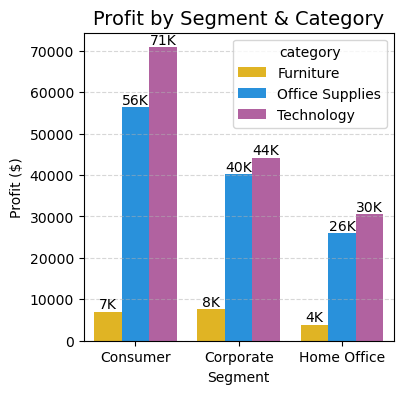

In [28]:
# Group profit by product segment
segment_profit = df.groupby(['segment','category'])[['profit']].sum().reset_index()

# Create canvas
plt.figure(figsize=(4, 4))

# bar chart
plot = sns.barplot(data=segment_profit, x='segment', y='profit', hue='category', palette=color3)
        
# add title
plt.title('Profit by Segment & Category', fontsize=14)
# set x & y label
plt.xlabel('Segment')
plt.ylabel('Profit ($)')
# add gridline
plt.grid(axis='y',linestyle='--', alpha=0.5)

# Add annotations
annotate_bars(plot)

# show()
plt.show()

**Similar Order of profit Across Segments**  
Technology category consistenly leads in profit across all segment, followed by Office Supply, then Furniture. Technology and office supplies category generate significantly higher profit than furniture, indicates a strong and stable demand for technology and office supplies products, which contributes significantly to profitability.

**Low Profitability of Furniture**  
The Furniture category has a noticeably lower profit margin compared to Technology and Office Supplies across all segments. This suggests underlying issues such as higher costs, pricing challenges, or less effective cost management in the Furniture category.

## Top 10 Spender

In [112]:
# group user by sales & order from most sales
cust_sales = df.groupby(['customer_id','segment'])['sales'].sum().sort_values(ascending=False).reset_index()

# top sales
cust_sales.head(10)

,customer_id,segment,sales
0,SM-20320,Home Office,25043.050
1,TC-20980,Corporate,19052.218
2,RB-19360,Consumer,15117.339
3,TA-21385,Home Office,14595.620
4,AB-10105,Consumer,14473.571
5,KL-16645,Consumer,14175.229
6,SC-20095,Consumer,14142.334
7,HL-15040,Consumer,12873.298
8,SE-20110,Consumer,12209.438
9,CC-12370,Consumer,12129.072


**Consumer Segment Dominance**   
The Consumer segment has the most representatives in the top 10 spenders list, showing consistent high-value customers. Focusing on loyalty programs and personalized marketing can help retain these valuable customers.

## Buy Trend Across Segments

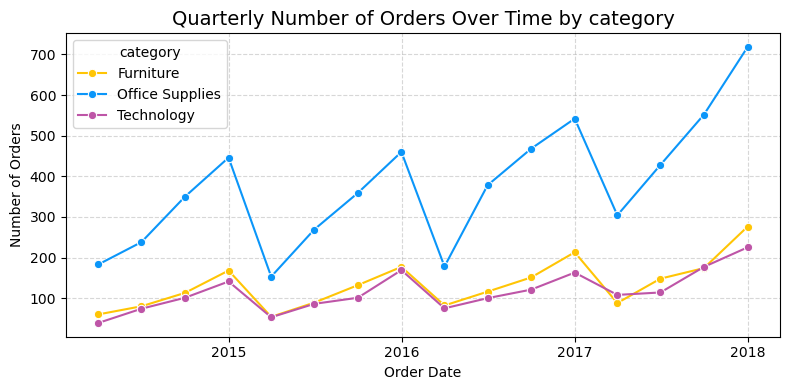

In [97]:
# Group data by order_date, category, and count the number of orders
daily_orders = df.groupby(['order_date', 'category']).size().reset_index(name='num_orders')

# Resample data to quarterly frequency, summing the number of orders in each quarter
quarterly_orders = daily_orders.set_index('order_date').groupby('category').resample('QE')['num_orders'].sum().reset_index()

# Create a canvas
plt.figure(figsize=(8, 4))

# Create line plot with hue for categorys
sns.lineplot(data=quarterly_orders, x='order_date', y='num_orders', hue='category', marker='o', palette=color)

# Set major locator and formatter for x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add title and labels
plt.title('Quarterly Number of Orders Over Time by category', fontsize=14)
# set x&y label
plt.xlabel('Order Date')
plt.ylabel('Number of Orders')
# add grid
plt.grid(linestyle='--', alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()


**Consistent Trends Across Categories**   
The number of orders dips to its lowest in the first quarter of each year due to post-holiday seasonality, then steadily increases throughout the quarter, probably driven by factors like back-to-school shopping and holiday season demand. The similar trend observed across all categories suggests that the seasonal impact affects the entire product range.

# Summary